In [5]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import csv
import openpyxl
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble

plt.rcParams['figure.figsize'] = (10.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


#### This data has some weird encoding issues... need a helper function

### Convert xlsx to csv, dealing with encoding issues
Notes: 
* made a file with just three columns, date, reviews and 2_or_more_ill
* also dropped '3' and '9' labels because they can't help (and there's only like 5 total)


### Now let's write out the data we care about (but only the first 1/3) 

#### And check that it looks good

## Cool.  So let's start messing with classification

### Define our (very basic) classifier pipeline

In [6]:
from sklearn.pipeline import Pipeline

# Feature Extractors
from sklearn.feature_extraction.text import CountVectorizer
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        #token_pattern=u'(?u)\\b\w\w+\b', # one alphanumeric is a token
        ngram_range=(1, 1), 
        analyzer=u'word', 
        max_df=1.0, 
        min_df=1, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        #dtype=type 'numpy.int64'>
        )

from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
rf = ensemble.RandomForestRegressor(
    oob_score = True,
    random_state =0
)
from sklearn import linear_model
log = linear_model.LogisticRegression()
#Decision Tree Pipeline
pipeline = Pipeline([
        ('count', f1),
        ('tfidf', tfidf),
        ('log', log)
    ])

In general, we are most interested in a classifier that positively labels as many true positives as possible. 
This is equivalent to maximizing the Positive label recall, so define that scoring function

In [7]:
from sklearn.metrics import make_scorer

def my_roc_auc(ground_truth, predictions):
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    return metrics.roc_auc_score(ground_truth, predictions, average='micro')

def ms_error(ground_truth, predictions):
    ## Calculate rmse for reviews that have real label of 'yes'
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    real_yes = ground_truth[np.where(ground_truth == 1)]
    pred_for_yes = predictions[np.where(ground_truth == 1)] ## predicted value for 'yes' reviews'
    y_error = metrics.mean_squared_error(real_yes, pred_for_yes) **.5 ## rmse for 'yes' reviews
    
    ## Calculate rmse for reviews that have real label of 'yes'
    real_no = ground_truth[np.where(ground_truth == 0)]
    pred_for_no = predictions[np.where(ground_truth == 0)] ## predicted value for 'no' reviews
    n_error = metrics.mean_squared_error(real_no, pred_for_no) **.5 ## rmse for 'no' reviews
    
    print y_error
    print n_error
    ## F2 score, weighted to favor y_error
    ##error = ( (2**2 + 1) * y_error * n_error) / (y_error + (2**2) * n_error) 
    error = (2.0/3.0) * y_error + (1.0/3.0) * n_error
    return error
    #return metrics.mean_squared_error(ground_truth, predictions)

    
def pos_recall(ground_truth, predictions, pos_label='yes'):
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    true_preds = predictions[np.where(ground_truth == pos_label)]
    true_pos = ground_truth[np.where(ground_truth == pos_label)]
    return float(len(true_preds[np.where(true_preds == true_pos)]))/len(true_pos)

ms_error_scorer = make_scorer(ms_error, greater_is_better=True)
pos_recall_scorer = make_scorer(pos_recall, greater_is_better=True)
my_roc_auc_scorer = make_scorer(my_roc_auc, needs_threshold=True, greater_is_better=True)

### Here are two functions to generate plots

In [8]:
def plot_histo(values, nbins=50, xlabel="Value", ylabel="Frequency", title="Histogram"):
    plt.hist(values, nbins, color='cadetblue')
    plt.title(title)     
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

### These three functions split up the basic initial steps of an experiment

In [9]:
from sklearn import preprocessing
def load_data(csvfile, delim):
    data = { 'x':[], 'y':[]}
    with open(csvfile, 'r') as f:
        reader = csv.reader(f, delimiter=delim)
        print "HEADERS: ", reader.next()
        for row in reader:
            data['x'].append(row[0])
#             print row[1]
            data['y'].append(row[1])
    data['x'] = np.array(data['x'])
    data['y'] = np.array(data['y'])
    
    for i in range (len(data['y'])):
        if data['y'][i] == '0':
            data['y'][i] = 0.0
        else:
            data['y'][i] = 1.0
            
    lb = preprocessing.LabelEncoder()
    data['y'] = lb.fit_transform(data['y'])
    
    n = len(data['y'])
    labels = sorted(list(set(data['y'])))
    print "Labels: ", labels
    pos = [d for d in data['y'] if d==1] 
    print "Positive Examples: %i = %0.2f" % (len(pos), len(pos)/float(n))
    neg = [d for d in data['y'] if d==0] 
    print "Negative Examples: %i = %0.2f" % (len(neg), len(neg)/float(n))
    return data, labels

def split_dev_test(data, test_size=.2):
    train_data = {}
    test_data = {}
    for train, test in cross_validation.StratifiedShuffleSplit(data['y'], n_iter=1, test_size=test_size, random_state=0):
        train_data['x'] = data['x'][train]
        train_data['y'] = data['y'][train]
        test_data['x'] = data['x'][test]
        test_data['y'] = data['y'][test]
        
    print "Training/Dev data shape: ", train_data['x'].shape, train_data['y'].shape
    print "Test data shape: ",test_data['x'].shape, test_data['y'].shape
    return train_data, test_data

def parameter_search(data, pipeline, paramgrid, n_folds=3, gscv_kwargs=None):
    print "SEARCHING PARAMETER SPACE:"
    folds = cross_validation.StratifiedKFold(data['x'], n_folds=n_folds, random_state=0,shuffle=True)
    if not gscv_kwargs:
        gscv_kwargs = {
             'scoring':my_roc_auc_scorer, 
             'fit_params':None, 
             'n_jobs':1, 
             'iid':True, 
             'refit':True, 
             'cv':folds, 
             'verbose':2, 
    #                  pre_dispatch=None, 
             'error_score':'raise'
        }
    gscv = grid_search.GridSearchCV(pipeline, paramgrid, **gscv_kwargs)
    gscv.fit(data['x'], data['y'])
    return gscv



### Load Data

In [35]:
csvfile = 'mult_data.csv'
delim=','
old_data, old_labels = load_data(csvfile, delim)
#print np.array(old_pred).shape, np.array(old_labels).shape
my_roc_auc(old_data['y'], old_data['x']) #true values, then predictions

HEADERS:  ['Multiple', '2OrMoreAsBool (Health Dept. Val)']
Labels:  [0, 1]
Positive Examples: 779 = 0.12
Negative Examples: 5497 = 0.88
[ 0.   0.   0.  ...,  1.8  4.4  4.4]
[1 1 1 ..., 0 0 0]


0.65094299306215109

In [10]:
csvfile = 'yelp_sick_data_small.csv'
delim=','
data, labels = load_data(csvfile, delim)

HEADERS:  ['data', 'label']
Labels:  [0, 1]
Positive Examples: 742 = 0.53
Negative Examples: 650 = 0.47


### Now split the data into a training/dev set and a final test set
(It is poor practice to tune parameters and evaluate performance on the same 'test' dataset.

So usually people actually split the data into 3 sets: train/development/test

In [11]:
train_data, test_data = split_dev_test(data)

Training/Dev data shape:  (1113,) (1113,)
Test data shape:  (279,) (279,)


### Paramter Grid Search

In [32]:
param_grid = {
    'count__ngram_range': [(1, 3)],
    'count__max_df' : [.75, .775, .80, .825, .85, .925, .95, .975, 1.0],
    'count__stop_words': [None],
    'count__lowercase' : [True],
    'count__max_features': [None],
    'tfidf__use_idf' : [True],
    'tfidf__norm': [('l1'), ('l2'), None],
    'log__C': [ .01, .1, .5, 1, 5, 10, 50, 100, 150],
    'log__dual' : [True],
    'log__fit_intercept': [True],
    'log__penalty': ['l2'],
    'log__intercept_scaling':[.01, .1, .5, 1, 5, 10, 50, 100, 150],
    'log__random_state': [57],
    'log__solver': ['liblinear']
}
tuning_results = parameter_search(train_data, pipeline, param_grid)

SEARCHING PARAMETER SPACE:
Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[CV] count__stop_words=None, count__max_df=0.75, log__penalty=l2, tfidf__norm=l1, log__random_state=57, log__intercept_scaling=0.01, log__C=0.01, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.75, log__penalty=l2, tfidf__norm=l1, log__random_state=57, log__intercept_scaling=0.01, log__C=0.01, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None -   1.5s
[CV] count__stop_words=None, count__max_df=0.75, log__penalty=l2, tfidf__norm=l1, log__random_state=57, log__intercept_scaling=0.01, log__C=0.01, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, coun

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done 161 tasks       | elapsed:  4.4min



[CV] count__stop_words=None, count__max_df=0.75, log__penalty=l2, tfidf__norm=None, log__random_state=57, log__intercept_scaling=150, log__C=0.1, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.75, log__penalty=l2, tfidf__norm=None, log__random_state=57, log__intercept_scaling=150, log__C=0.1, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None -   1.7s
[CV] count__stop_words=None, count__max_df=0.75, log__penalty=l2, tfidf__norm=l1, log__random_state=57, log__intercept_scaling=0.01, log__C=0.5, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.75, log__penalty=l2, tfi

[Parallel(n_jobs=1)]: Done 364 tasks       | elapsed:  9.9min
[Parallel(n_jobs=1)]: Done 647 tasks       | elapsed: 17.7min



[CV] count__stop_words=None, count__max_df=0.75, log__penalty=l2, tfidf__norm=None, log__random_state=57, log__intercept_scaling=150, log__C=100, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.75, log__penalty=l2, tfidf__norm=None, log__random_state=57, log__intercept_scaling=150, log__C=100, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None -   1.5s
[CV] count__stop_words=None, count__max_df=0.75, log__penalty=l2, tfidf__norm=l1, log__random_state=57, log__intercept_scaling=0.01, log__C=150, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.75, log__penalty=l2, tfi

[Parallel(n_jobs=1)]: Done 1012 tasks       | elapsed: 39.3min
[Parallel(n_jobs=1)]: Done 1457 tasks       | elapsed: 51.4min



[CV] count__stop_words=None, count__max_df=0.775, log__penalty=l2, tfidf__norm=None, log__random_state=57, log__intercept_scaling=150, log__C=150, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.775, log__penalty=l2, tfidf__norm=None, log__random_state=57, log__intercept_scaling=150, log__C=150, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None -   1.6s
[CV] count__stop_words=None, count__max_df=0.8, log__penalty=l2, tfidf__norm=l1, log__random_state=57, log__intercept_scaling=0.01, log__C=0.01, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.8, log__penalty=l2, tf

[Parallel(n_jobs=1)]: Done 1984 tasks       | elapsed: 65.7min
[Parallel(n_jobs=1)]: Done 2591 tasks       | elapsed: 98.0min



[CV] count__stop_words=None, count__max_df=0.825, log__penalty=l2, tfidf__norm=None, log__random_state=57, log__intercept_scaling=150, log__C=5, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.825, log__penalty=l2, tfidf__norm=None, log__random_state=57, log__intercept_scaling=150, log__C=5, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None -   1.5s
[CV] count__stop_words=None, count__max_df=0.825, log__penalty=l2, tfidf__norm=l1, log__random_state=57, log__intercept_scaling=0.01, log__C=10, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.825, log__penalty=l2, tfid

[Parallel(n_jobs=1)]: Done 3280 tasks       | elapsed: 115.6min
[Parallel(n_jobs=1)]: Done 4049 tasks       | elapsed: 135.2min



[CV] count__stop_words=None, count__max_df=0.925, log__penalty=l2, tfidf__norm=None, log__random_state=57, log__intercept_scaling=150, log__C=5, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.925, log__penalty=l2, tfidf__norm=None, log__random_state=57, log__intercept_scaling=150, log__C=5, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None -   1.5s
[CV] count__stop_words=None, count__max_df=0.925, log__penalty=l2, tfidf__norm=l1, log__random_state=57, log__intercept_scaling=0.01, log__C=10, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.925, log__penalty=l2, tfid

[Parallel(n_jobs=1)]: Done 4900 tasks       | elapsed: 156.6min
[Parallel(n_jobs=1)]: Done 5831 tasks       | elapsed: 180.3min



[CV] count__stop_words=None, count__max_df=0.975, log__penalty=l2, tfidf__norm=None, log__random_state=57, log__intercept_scaling=150, log__C=150, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=0.975, log__penalty=l2, tfidf__norm=None, log__random_state=57, log__intercept_scaling=150, log__C=150, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None -   1.6s
[CV] count__stop_words=None, count__max_df=1.0, log__penalty=l2, tfidf__norm=l1, log__random_state=57, log__intercept_scaling=0.01, log__C=0.01, log__solver=liblinear, log__dual=True, tfidf__use_idf=True, count__ngram_range=(1, 3), log__fit_intercept=True, count__lowercase=True, count__max_features=None 
[CV]  count__stop_words=None, count__max_df=1.0, log__penalty=l2, tf

[Parallel(n_jobs=1)]: Done 6561 out of 6561 | elapsed: 199.0min finished


With these results, we can see what the general distribution of classifcation results looked like

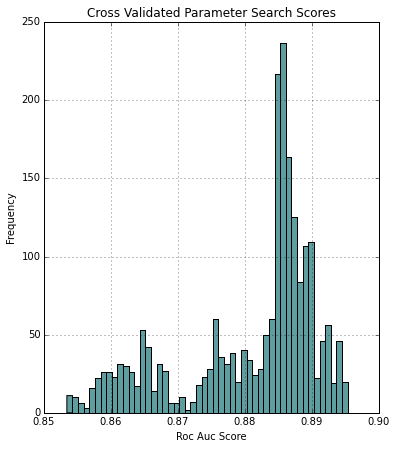

In [33]:
scores = [r.mean_validation_score for r in tuning_results.grid_scores_]        
plot_histo(scores,
           title="Cross Validated Parameter Search Scores",
           xlabel="Roc Auc Score")



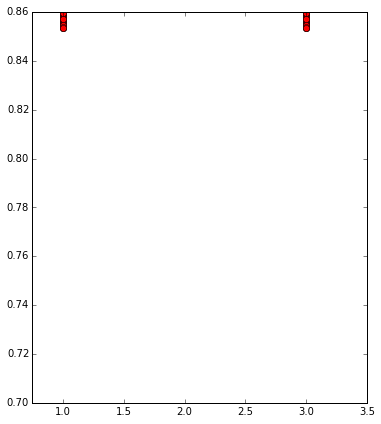

In [34]:
ngram_range = [r.parameters['count__ngram_range'] for r in tuning_results.grid_scores_]
plt.plot(ngram_range, scores, 'ro')
plt.axis([.75, 3.5, .7, .86])
plt.show()

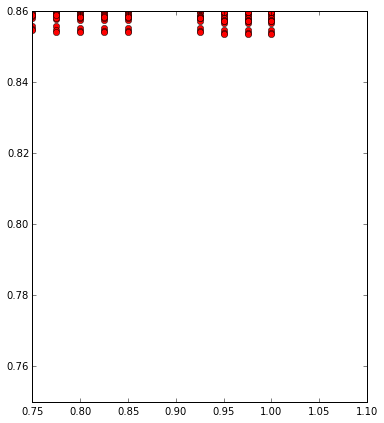

In [35]:
##max_df
max_df = [r.parameters['count__max_df'] for r in tuning_results.grid_scores_]
plt.plot(max_df, scores, 'ro')
plt.axis([.75, 1.1, .75, .86])
plt.show()

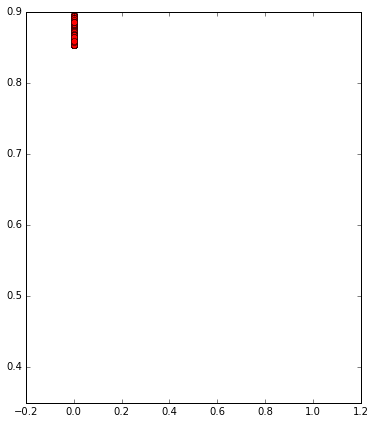

In [36]:
##min_df
s_words = [r.parameters['count__stop_words'] for r in tuning_results.grid_scores_]
for i in range(len(s_words)):
    if s_words[i] == None:      
        s_words[i] = 0
    else:
        s_words[i] = 1
plt.plot(s_words, scores, 'ro')
plt.axis([-.2, 1.2, .35, .9])
plt.show()

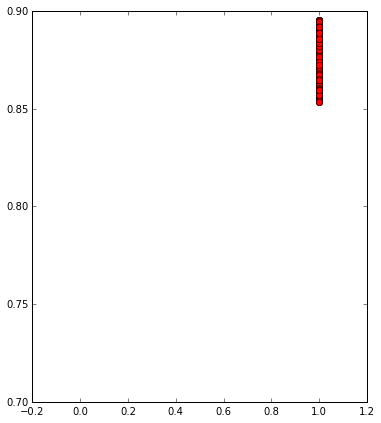

In [37]:
##Lowercase
case = [r.parameters['count__lowercase'] for r in tuning_results.grid_scores_]
for i in range(len(case)):
    if case[i] == False:      
        case[i] = 0
    else:
        case[i] = 1
plt.plot(case, scores, 'ro')
plt.axis([-.2, 1.2, .7, .9])
plt.show()

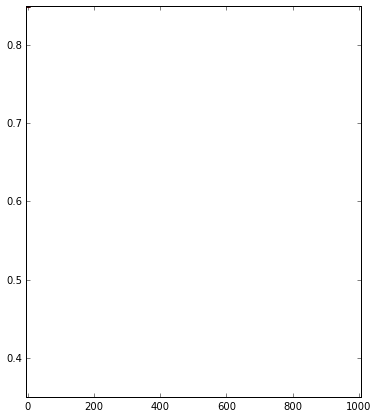

In [38]:
##Max Features
max_ft = [r.parameters['count__max_features'] for r in tuning_results.grid_scores_]
for i in range(len(max_ft)):
    if max_ft[i] == None: 
        max_ft[i] = 0

plt.plot(max_ft, scores, 'ro')
plt.axis([-5, 1005, .35, .85])
plt.show()

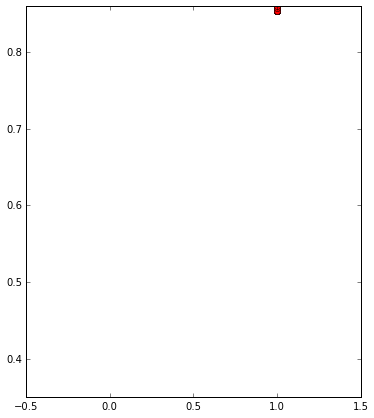

In [39]:
##Use_IDF
use_idf = [r.parameters['tfidf__use_idf'] for r in tuning_results.grid_scores_]
for i in range(len(use_idf)):
    if use_idf[i] == False: 
        use_idf[i] = 0
    else:
        use_idf[i] = 1

plt.plot(use_idf, scores, 'ro')
plt.axis([-.5, 1.5, .35, .86])
plt.show()

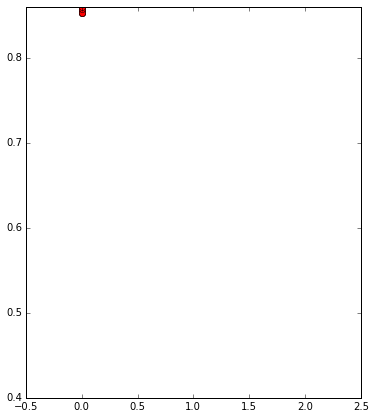

In [40]:
##Norm
norm = [r.parameters['tfidf__norm'] for r in tuning_results.grid_scores_]
for i in range(len(norm)):
    if norm[i] == None:      
        norm[i] = 0
    elif norm[i] == 'l1':
        norm[i] = 1
    else:
        norm[i] = 2
plt.plot(norm, scores, 'ro')
plt.axis([-.5, 2.5, .4, .86])
plt.show()

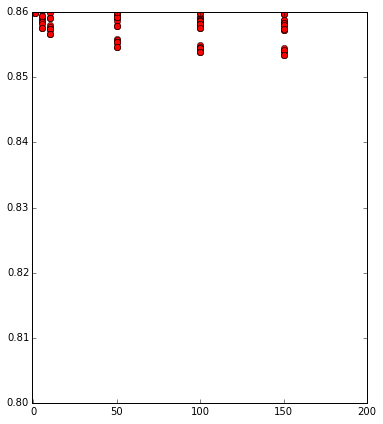

In [41]:
##C
c = [r.parameters['log__C'] for r in tuning_results.grid_scores_]
plt.plot(c, scores, 'ro')
plt.axis([-.5, 200, .8, .86])
plt.show()

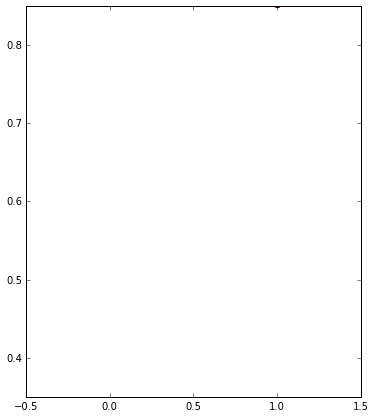

In [42]:
##Dual
dual = [r.parameters['log__dual'] for r in tuning_results.grid_scores_]
for i in range(len(dual)):
    if dual[i] == False: 
        dual[i] = 0
    else:
        dual[i] = 1

plt.plot(dual, scores, 'ro')
plt.axis([-.5, 1.5, .35, .85])
plt.show()

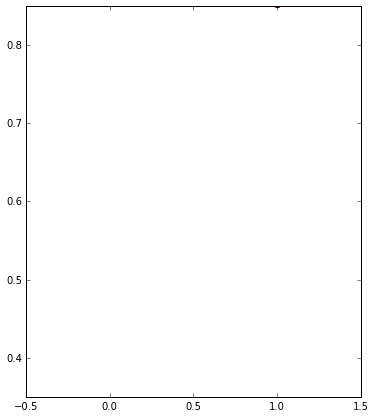

In [43]:
##Fit Intercept
f_int = [r.parameters['log__fit_intercept'] for r in tuning_results.grid_scores_]
for i in range(len(f_int)):
    if f_int[i] == False: 
        f_int[i] = 0
    else:
        f_int[i] = 1

plt.plot(f_int, scores, 'ro')
plt.axis([-.5, 1.5, .35, .85])
plt.show()

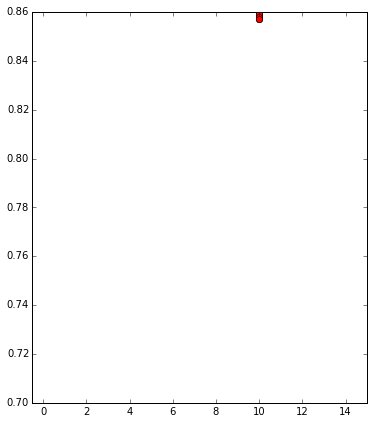

In [44]:
##Intercept Scaling
scaling = [r.parameters['log__intercept_scaling'] for r in tuning_results.grid_scores_]
plt.plot(scaling, scores, 'ro')
plt.axis([-.5, 15, .7, .86])
plt.show()

In [45]:
plt.rcParams['figure.figsize'] = (6,7)
topk = 3
ranked_results = sorted(tuning_results.grid_scores_, key=lambda x:x.mean_validation_score, reverse=True)
best_score = 1 ## 1 is highest
best_index = 0
best_params = None
for i, result in enumerate(ranked_results[:topk]):
    params = result.parameters
    pipeline.set_params(**params).fit(train_data['x'], train_data['y'])
    train_preds = pipeline.predict_proba(train_data['x'])
    test_preds = pipeline.predict_proba(test_data['x'])
    
    train_pred_arr = np.array(train_preds)
    train_preds_pos_column = train_pred_arr[:,1]
    
    test_pred_arr = np.array(test_preds)
    test_preds_pos_column = test_pred_arr[:,1]

    print "GRID SEARCH SCORE: %0.4f" % result.mean_validation_score
    print "TRAIN SCORE: %0.4f" % metrics.roc_auc_score(train_data['y'], train_preds_pos_column, average='micro')
    test_score = metrics.roc_auc_score(test_data['y'], test_preds_pos_column, average='micro')
    print "TEST SCORE: %0.4f" % test_score
    print params
    if test_score < best_score: 
        best_score=test_score
        best_index = i
        best_params = params
    print '*****************'

GRID SEARCH SCORE: 0.8954
TRAIN SCORE: 1.0000
TEST SCORE: 0.8878
{'count__stop_words': None, 'count__max_df': 0.95, 'log__penalty': 'l2', 'tfidf__norm': 'l2', 'log__random_state': 57, 'log__intercept_scaling': 0.01, 'log__C': 100, 'log__solver': 'liblinear', 'log__dual': True, 'tfidf__use_idf': True, 'count__ngram_range': (1, 3), 'log__fit_intercept': True, 'count__lowercase': True, 'count__max_features': None}
*****************
GRID SEARCH SCORE: 0.8954
TRAIN SCORE: 1.0000
TEST SCORE: 0.8878
{'count__stop_words': None, 'count__max_df': 0.975, 'log__penalty': 'l2', 'tfidf__norm': 'l2', 'log__random_state': 57, 'log__intercept_scaling': 0.01, 'log__C': 100, 'log__solver': 'liblinear', 'log__dual': True, 'tfidf__use_idf': True, 'count__ngram_range': (1, 3), 'log__fit_intercept': True, 'count__lowercase': True, 'count__max_features': None}
*****************
GRID SEARCH SCORE: 0.8954
TRAIN SCORE: 1.0000
TEST SCORE: 0.8878
{'count__stop_words': None, 'count__max_df': 1.0, 'log__penalty': 'l

### Given the best test score, we can see what those parameters were, and save the model to a file if we want to use it later

In [117]:
best = ranked_results[best_index]
print "BEST TEST POSITIVE RECALL: %0.4f" % best_score
print "BEST MODEL PARAMS: %r" % best_params
model = pipeline.set_params(**best_params).fit(data['x'], data['y'])

BEST TEST POSITIVE RECALL: 0.8852
BEST MODEL PARAMS: {'count__stop_words': None, 'count__max_df': 1.0, 'count__ngram_range': (1, 2), 'count__min_df': 1, 'log__C': 1000, 'tfidf__use_idf': True, 'tfidf__norm': 'l1'}


In [118]:
from sklearn.externals import joblib
joblib.dump(model, 'log_reg_multiple_rf.pkl') 

['multiple_rf.pkl',
 'multiple_rf.pkl_01.npy',
 'multiple_rf.pkl_02.npy',
 'multiple_rf.pkl_03.npy',
 'multiple_rf.pkl_04.npy',
 'multiple_rf.pkl_05.npy',
 'multiple_rf.pkl_06.npy']

Don't worry about why that has multiple files, just know to load the model later all of those files must be in the directory.

But just refer to it with the original filename

In [ ]:
multiple = joblib.load('best_multiple_clf.pkl') 
preds = multiple.predict(data['x'])